## 3-1. 線形回帰モデル：線形単回帰モデル

In [1]:
%matplotlib inline

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### 3.1.1 モデル概要

$$
\begin{align*}
    y_n
        &= \mathbf{w}^\top \mathbf{\phi} (\mathbf{x_n}) + \varepsilon_n \\
        &= \sum_{m=1}^{M}w_\phi_m(\mathbf{x_n}) + \varepsilon_n \\
    \varepsilon_n &\sim \mathcal{N}(0, \sigma_{\varepsilon}^2)
\end{align*}
$$


### 3.1.2 実装

$$
\begin{align*}
    y_n = w_1 x_n + w_2 + \varepsilon_n \\
    \varepsilon_n \sim \mathcal{N}(0, \sigma_{y}^2)
\end{align*}
$$

$w_1, w_2$ の事前分布は以下とする
$$
\begin{align*}
    w_1 \sim \mathcal{N}(0, \sigma_{w_1}^2) \\
    w_2 \sim \mathcal{N}(0, \sigma_{w_2}^2)
\end{align*}
$$

テストデータは以下の通り.

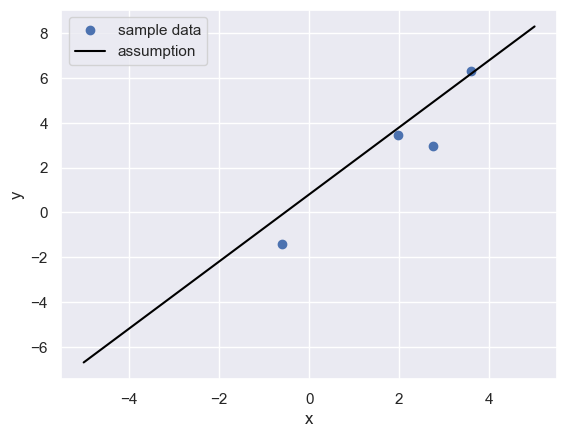

In [2]:
# 真のパラメータ
true_w1 = 1.5
true_w2 = 0.8

# サンプルデータ
N = 4
rng = np.random.default_rng(seed=42)
x_data = rng.uniform(-5, 5, size=N)
y_data = true_w1 * x_data + true_w2 + rng.normal(0., 1., size=N)

# データの描画
x_plot_data = np.linspace(-5, 5, 100)
y_plot_data = true_w1 * x_plot_data + true_w2

plt.scatter(x=x_data, y=y_data, marker="o", label="sample data")
plt.plot(x_plot_data, y_plot_data, color="black", label="assumption")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

``pymc3`` によって実装, 構築する.

In [3]:
# warning が発生しているが, 動かしているマシンが Apple M1 で Intel MKL に非対応のため?
import pymc3 as pm

In [4]:
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data)

    # 推論パラメータの事前分布
    w1 = pm.Normal("w1", mu=0.0, sigma=10.0)
    w2 = pm.Normal("w2", mu=0.0, sigma=10.0)

    # 尤度関数
    y = pm.Normal("y", mu=w1*x + w2, sigma=1.0, observed=y_data)

In [5]:
with model:
    # MCMC による推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w2, w1]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 11 seconds.


array([[<AxesSubplot:title={'center':'w1'}>,
        <AxesSubplot:title={'center':'w1'}>],
       [<AxesSubplot:title={'center':'w2'}>,
        <AxesSubplot:title={'center':'w2'}>]], dtype=object)

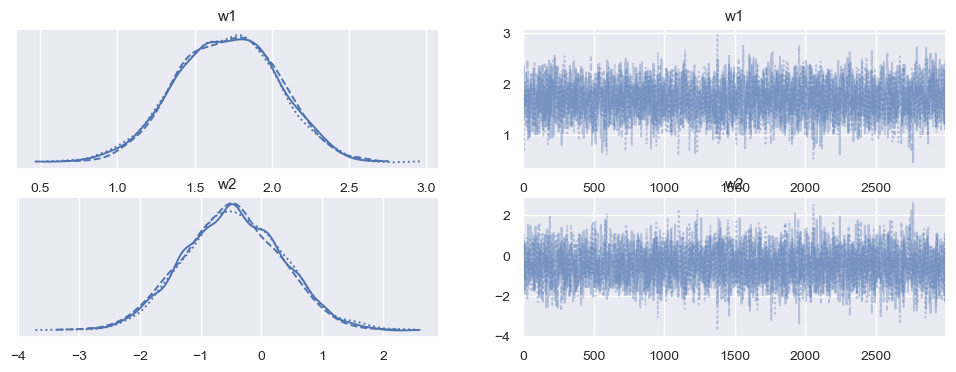

In [6]:
az.plot_trace(trace)

In [7]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=" ")

w1 1.001
w2 1.001


array([<AxesSubplot:title={'center':'w1'}>,
       <AxesSubplot:title={'center':'w2'}>], dtype=object)

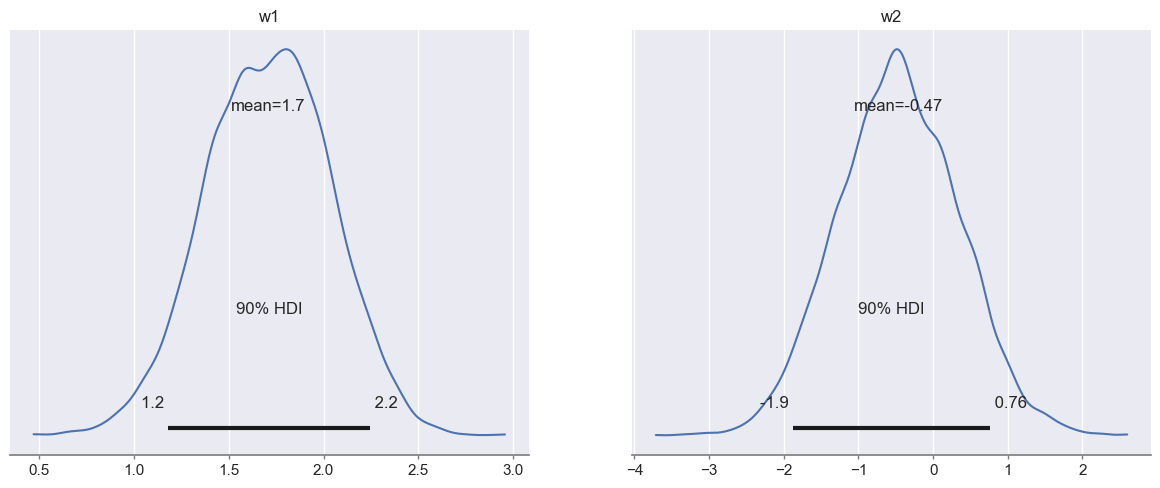

In [8]:
az.plot_posterior(trace, hdi_prob=0.90)

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


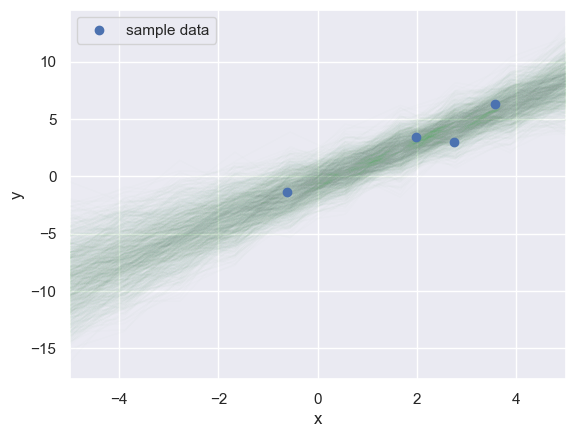

In [9]:
# 検証用データ
x_new = np.linspace(-5, 5, 10)

with model:
    # 検証用データを推論したモデルに入力
    pm.set_data({"x": x_new})

    # 予測分布からサンプリング
    pred = pm.sample_posterior_predictive(trace, samples=1000, random_seed=1)

y_pred_samples = pred["y"]

# 予測分布からのサンプルを描画
for i in range(1000):
    plt.plot(x_new, y_pred_samples[i,:], lw=1, alpha=0.01, color="g", zorder=i)

plt.scatter(x=x_data, y=y_data, marker="o", label="sample data", zorder=i+2)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-5, 5)
plt.legend()
plt.show()